# Introduction to TensorBoard

TensorBoard is a visualization and monitoring tool originally developed for TensorFlow, but it is fully compatible with PyTorch through the torch.utils.tensorboard API.
It allows you to track and understand what happens during the training of neural networks by providing real-time, interactive visualizations.

# Model and Dataset setup

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
)

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)

testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# split train into train and validation
train_size = int(0.9 * len(trainset))
valid_size = len(trainset) - train_size

train_subset, valid_subset = random_split(trainset, [train_size, valid_size])

# dataloaders 
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=4,
                                          shuffle=True, num_workers=0)

validloader = torch.utils.data.DataLoader(valid_subset, batch_size=4,
                                          shuffle=False, num_workers=0)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# TensorBoard setup

Now we’ll set up TensorBoard, importing tensorboard from torch.utils and defining a SummaryWriter, our key object for writing information to TensorBoard.

In [4]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

There are several ways to initialize a SummaryWriter, depending on how you want to structure and label your experiment logs. The examples below illustrate the most common options:

```python
# create a summary writer with automatically generated folder name.
writer = SummaryWriter()
# folder location: runs/May04_22-14-54_s-MacBook-Pro.local/

# create a summary writer using the specified folder name.
writer = SummaryWriter("my_experiment")
# folder location: my_experiment

# create a summary writer with comment appended.
writer = SummaryWriter(comment="LR_0.1_BATCH_16")
# folder location: runs/May04_22-14-54_s-MacBook-Pro.localLR_0.1_BATCH_16/
```

# Writing to TensorBoard

Now let’s write an image to our TensorBoard - specifically, a grid - using make_grid.

`make_grid` takes several images (a batch) and combines them into a single image arranged in a grid.
Internally, it:
* takes the tensor (B, C, H, W)
* arranges the images into rows and columns
* adds optional spacing (padding) between them
* returns a single tensor (C, H_grid, W_grid)

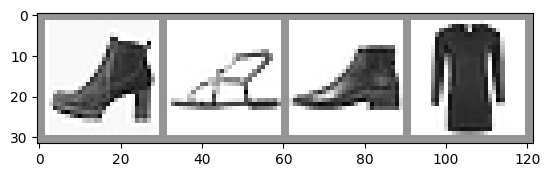

In [5]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

Now running
``
tensorboard --logdir=runs
``
from the command line and then navigating to http://localhost:6006 should show

# Inspect the model using TensorBoard

One of TensorBoard’s strengths is its ability to visualize complex model structures. Let’s visualize the model we built.

In [6]:
writer.add_graph(net, images)

Go ahead and double click on “Net” to see it expand.

# Adding a “Projector” to TensorBoard

We can visualize the lower dimensional representation of higher dimensional data via the `add_embedding` method.

## Principal Component Analysis (PCA)

### What is PCA?

Principal Component Analysis (PCA) is a statistical technique used to **reduce the dimensionality** of a dataset while preserving as much information (variance) as possible.
It transforms a set of possibly correlated variables into a new set of **uncorrelated variables**, called **principal components** (PCs).

PCA is useful when working with datasets that have many features, especially when some features are redundant or correlated. It helps with:

* visualization of high-dimensional data,
* identifying patterns and structure,
* removing noise,
* reducing model complexity.

---

### How to interpret PCA?

After applying PCA, you obtain new axes (PC1, PC2, PC3, …) that represent directions of maximal variance in the data.

**Interpretation principles:**

#### Principal components represent directions of variance

* **PC1** explains the largest amount of variance in the dataset.
* **PC2** explains the next largest amount of variance **and is orthogonal to PC1**.
* Subsequent PCs capture the remaining variance while remaining orthogonal to all previous components.

The first 2–3 components are often enough to show most of the structure in the data.

#### Scatter plots of principal components

A **PCA plot** (PC1 vs PC2) shows how samples relate to one another in the reduced feature space:

* points that cluster together = samples with similar patterns,
* outliers appear far from others,
* axes represent the strongest patterns in the data.

#### Loadings

Loadings describe how much each original variable contributes to each principal component.

* A large positive or negative loading means that the variable strongly influences the component.
* Loadings can be visualized as arrows:

  * **direction** shows correlation with the component,
  * **length** shows strength (magnitude of loading).

The interpretation:
**“Variables whose arrows point in a similar direction vary together.”**

#### Explained variance

Each component has an **explained variance ratio**, telling you how much of the original dataset’s information it retains.

* A **scree plot** visualizes this.
* Higher explained variance = more important component.

## t-SNE

### What is t-SNE?

t-SNE (t-distributed Stochastic Neighbor Embedding) is a **non-linear**, **unsupervised** dimensionality reduction technique used primarily for **visualizing high-dimensional data**.
Unlike PCA, which is linear, t-SSE is designed to preserve **local structure** and **small pairwise distances**, making it excellent for exploring complex datasets and revealing clusters.

t-SNE is especially useful when:

* the data does not follow a linear structure,
* there are many intertwined patterns,
* we want to visualize data in **2D or 3D** for interpretation.

Common applications include NLP embeddings, image feature visualizations, clustering inspection, anomaly detection, and exploratory data analysis.

---

### How to interpret t-SNE plots

t-SNE outputs a 2D or 3D scatter plot where:

* **points that appear close** - represent observations similar in the high-dimensional space,
* **points far apart** - represent dissimilar observations,
* **clusters** often represent meaningful groupings in the original data,
* **subclusters** may reveal fine-grained structure.

Important notes:

* The axes of a t-SNE plot have **no interpretable meaning**.
* Distances between clusters can sometimes be distorted; focus mainly on local neighborhoods.
* Changing hyperparameters (perplexity, learning rate) may produce different visualizations.

## UMAP

### What is UMAP?

UMAP (Uniform Manifold Approximation and Projection) is a **non-linear dimensionality reduction technique** designed to project high-dimensional data into a low-dimensional space (usually 2D or 3D).
It is based on principles from **manifold learning** and **topological data analysis**.

UMAP is similar to t-SNE but:

* preserves **both local and global structure** better,
* scales much more efficiently to large datasets,
* creates more stable, meaningful embeddings.

UMAP is widely used for **visualization, clustering, exploratory data analysis**, and as a **preprocessing step** for machine learning models.

---

### How to interpret UMAP plots

A UMAP plot shows a 2D or 3D embedding of the original high-dimensional data.

Basic interpretation rules:

* **Points close in the plot** → similar in high-dimensional space.
* **Points far apart** → dissimilar high-dimensional patterns.
* **Clusters** → groups of observations sharing similar features.
* **Cluster shapes and distances** can reflect broader topology (UMAP preserves more global structure than t-SNE).
* Axes have **no direct meaning**, similar to t-SNE.

UMAP plots often reveal:

* distinct clusters,
* subgroups within clusters,
* trajectories (common in genomics),
* outliers and unusual points.

In [7]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))

# Tracking model training with TensorBoard

Let’s train the model using the same model training code from the prior tutorial, but writing results to TensorBoard every 1000 batches instead of printing to console; this is done using the `add_scalar` function.

It's a good idea to log metrics during training, such as accuracy, F1-score, or loss values. This provides insights into your model's performance over time. 

## Loss function
One of the key metrics to monitor while training a model is loss, which gets calculated during the forward pass for each batch of data. The diagram below illustrates how loss can change over time and what its pattern reveals about the learning rate:

<img src="Images/loss.jpeg" height="450"> | <img src="Images/learningrates.jpeg" height="450">

**Left** This shows how different learning rates affect loss. With a low learning rate, improvements tend to be slow and steady, following a linear pattern. On the other hand, a high learning rate speeds up the decay of the loss but often leads to unstable optimization, where the loss doesn’t reach a good minimum because the parameters "bounce" chaotically (as seen in the green line).

**Right** This graph demonstrates a typical loss curve over time. While this curve seems reasonable, its slow decay might suggest a learning rate that’s too low. Additionally, the noisy fluctuations in the loss could indicate that the batch size is too small.

### Log scale
<img src="Images/log_scale.jpeg" height="450">

When to Use Each Loss Scale?

Normal Scale (Linear)
* Use when loss values are within a narrow range (e.g., 0.1 to 0.001).
* Best for stable, non-exponential loss curves.
* Easier to interpret for small loss changes.

Log Scale
* Use when loss spans multiple orders of magnitude (e.g., 100 → 0.001).
* Helps visualize small improvements in later epochs.
* Useful when loss decreases exponentially.
## Train/Val accuracy
Another important metric to track is accuracy, particularly on both the training and validation datasets. This can provide insight into whether the model is overfitting.

![Acc](Images/accuracies.jpeg)

The plot on the left shows two scenarios. In one case, the validation accuracy is significantly lower than the training accuracy, indicating overfitting. When this happens, you might want to add stronger regularization (like increasing dropout or using an L2 penalty) or collect more training data.

In the second scenario, the validation and training accuracies are closely aligned, which suggests the model lacks sufficient complexity. To improve in this case, you should increase the model size by adding more parameters.

In [8]:
def evaluate_accuracy(loader, net):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    net.train()
    return correct / total

In [ ]:
from tqdm import tqdm

running_loss = 0.0
running_correct = 0
running_total = 0

for epoch in range(1):  # loop over the dataset multiple times
    
    pbar = tqdm(enumerate(trainloader, 0), total=len(trainloader))
    pbar.set_description(f"Epoch {epoch+1}")

    for i, data in pbar:

        # inputs
        inputs, labels = data

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # accumulate loss
        running_loss += loss.item()

        # accuracy (train)
        _, predicted = torch.max(outputs.data, 1)
        running_total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        # LIVE UPDATE TQDM 
        if i % 20 == 0:
            avg_loss = running_loss / (i + 1)
            train_acc = running_correct / running_total

            pbar.set_postfix({
                "loss": f"{avg_loss:.4f}",
                "acc": f"{train_acc:.3f}"
            })

        if i % 1000 == 999:
            avg_loss = running_loss / 1000
            train_acc = running_correct / running_total

            # walidacja
            val_acc = evaluate_accuracy(validloader, net)

            # TensorBoard log: training loss
            writer.add_scalar('training loss', avg_loss,
                              epoch * len(trainloader) + i)

            # TensorBoard: accuracy (train vs val)
            writer.add_scalars('accuracy', {
                'train': train_acc,
                'val': val_acc
            }, epoch * len(trainloader) + i)

            # reset counters
            running_loss = 0.0
            running_correct = 0
            running_total = 0

print('Finished Training')


Epoch 1: 100%|██████████| 13500/13500 [00:17<00:00, 775.13it/s, loss=0.0149, acc=0.843] 

Finished Training


# Assessing trained models with TensorBoard

You will now see a “PR Curves” tab that contains the precision-recall curves for each class. Go ahead and poke around; you’ll see that on some classes the model has nearly 100% “area under the curve”, whereas on others this area is lowe

In [10]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
class_probs = []
class_label = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)

writer.close()

# Bibliography

[Visualizing Models, Data, and Training with TensorBoard](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)